In [1]:
import pandas as pd
import numpy as np
import random
import csv
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from time import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math
import random
from imblearn.over_sampling import SMOTE

In [54]:
url = "D:\\TUGAS AKHIR\\Data TA\\bkbk.csv"
data = pd.read_csv(url, header = 0)
data = data.sample(n=5000, random_state = 42)
fraud_flag = data["fraud_flag"]
data["created_date_trx"] = pd.to_datetime(data["created_date_trx"])
data = data.sort_values(by=['created_date_trx'])

In [55]:
# Get one hot encoding of columns B

data = data.drop(columns = ["trx_no","name_subcategory", "stuff_id", "seller_id","invoice_id"])
one_hot = pd.get_dummies(data["name_category"])
# Drop column B as it is now encoded
data = data.drop("name_category",axis = 1)
# Join the encoded df
data = data.join(one_hot)

In [56]:
data.fraud_flag.value_counts()

0    4831
1     169
Name: fraud_flag, dtype: int64

In [57]:
stats = data.groupby('user_id')['stuff_price'].agg(['mean', 'max', 'min'])
stats.columns = ['user_mean_stuff_price', 'user_max_stuff_price', 'user_min_stuff_price']
data = data.merge(stats, left_on = 'user_id', right_index=True, how = 'left')
data.sort_values(by=['user_id'])

stats = data.groupby('user_id')['DISCOUNT'].agg(['mean', 'sum'])
stats.columns = ['user_mean_DISCOUNT', 'user_sum_DISCOUNT']
data = data.merge(stats, left_on = 'user_id', right_index=True, how = 'left')
data.sort_values(by=['user_id'])

stats = data.groupby('user_id')['quantity'].agg(['sum'])
stats.columns = ['user_total_quantity']
data = data.merge(stats, left_on = 'user_id', right_index=True, how = 'left')



In [58]:
data = data.assign(last_buy = data.groupby('user_id').created_date_trx.apply(lambda x: x - x.iloc[0]))
data = data.sort_values(by=['user_id'])
data['last_buy'] = data['last_buy'].array.seconds
data = data.drop(columns = ["created_date_trx"])

In [59]:
data[['quantity','stuff_price', 'DISCOUNT', 'shipping_cost','user_mean_stuff_price','user_max_stuff_price','user_min_stuff_price','user_mean_DISCOUNT','user_sum_DISCOUNT','user_total_quantity','last_buy']] = StandardScaler().fit_transform(data[['quantity','stuff_price', 'DISCOUNT', 'shipping_cost','user_mean_stuff_price','user_max_stuff_price','user_min_stuff_price','user_mean_DISCOUNT','user_sum_DISCOUNT','user_total_quantity','last_buy']])

In [60]:
X = data.drop(columns = ["user_id", 'fraud_flag'])
y = data['fraud_flag']
sm = SMOTE()
X, y = sm.fit_sample(X,y)
X = pd.DataFrame(X)
X['y'] = y
X = X.reindex(np.random.permutation(X.index))

y = X['y']
X = X.drop(columns = ['y'])
X.head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
669,-0.181254,-0.038873,-0.303955,-0.308383,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.040893,-0.067338,-0.008193,-0.320938,-0.472961,-0.231610,-0.273886
6564,-0.181254,-0.213209,-0.303955,-0.628160,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.224285,-0.227286,-0.200322,-0.320938,-0.472961,-0.231610,-0.273886
9101,-0.116957,-0.268473,-0.540651,-0.529155,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.307557,-0.277989,-0.313895,-0.445898,-0.472961,-0.092523,-0.273886
1646,-0.181254,0.156007,-1.377060,0.381529,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.164111,0.111459,0.206577,-1.453998,-1.142930,-0.231610,-0.273886
270,-0.181254,6.073278,-0.303955,-0.115208,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.388786,5.540398,6.727788,-0.320938,-0.472961,-0.231610,-0.273886


In [61]:
y

669     0
6564    1
9101    1
1646    0
270     0
1327    0
4218    0
4382    0
5947    1
4943    0
3453    0
8701    1
2290    0
885     0
744     0
6778    1
1536    0
3188    0
4877    0
63      0
9132    1
5419    1
2053    0
5828    1
5570    1
3911    0
437     0
1762    0
6288    1
873     0
       ..
5606    1
8626    1
7899    1
2837    0
1518    0
8654    1
2446    0
1081    0
3959    0
5565    1
6020    1
3827    0
2735    0
8909    1
7504    1
2501    0
3711    0
5664    1
2622    0
395     0
4249    0
2212    0
1920    0
3891    0
8495    1
751     0
6526    1
7356    1
6461    1
6531    1
Name: y, Length: 9662, dtype: int64

In [62]:
K = 0.3
c1 = 2.05
c2 = 2.05
c = c1 + c2
khi = 2*K/(abs(2-c-math.sqrt(c**2-4*c)))
n_iterations = 10
n_particles = 100

def fitness_function(position):
    kf = KFold(n_splits = 3)
    svclassifier = SVC(kernel='rbf', gamma = position[0], C = position[1] )  
   # svclassifier.fit(X_train, y_train)
    scores = cross_val_score(svclassifier, X, y, cv = kf, scoring = 'roc_auc')
    return np.mean(scores)
   # y_train_pred = svclassifier.predict(X_train)
   # y_test_pred = svclassifier.predict(X_test)   
   # return (confusion_matrix(y_train,y_train_pred)[0][1] + confusion_matrix(y_train,y_train_pred)[1][0])/np.sum(confusion_matrix(y_train,y_train_pred)), (confusion_matrix(y_test,y_test_pred)[0][1] + confusion_matrix(y_test,y_test_pred)[1][0])/np.sum(confusion_matrix(y_test,y_test_pred))

#plotting (x axis = gamma, y axis = C)
def plot(position):
    x = []
    y = []
    for i in range(0,len(particle_position_vector)):
        x.append(particle_position_vector[i][0])
        y.append(particle_position_vector[i][1])
    colors = (0,0,0)
    plt.scatter(x, y, c = colors, alpha = 0.3)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.axis([-1,11,-1,11])
    plt.gca().set_aspect('equal', adjustable='box')
    return plt.show()

for i in range(n_particles):
    max_velocity = np.array([10,10])
    min_velocity = np.array([-10,-10])
    max_position = np.array([10,10])
    min_position = np.array([0.0001, 0.001])

def eval_velocity(new_velocity):
    for j in range(0,2):
        if(new_velocity[j] > max_velocity[j]):
            new_velocity[j] = max_velocity[j]
        elif(new_velocity[j] < min_velocity[j]):
            new_velocity[j] = min_velocity[j]
    return new_velocity

def eval_position(particle_position_vector):
    for j in range(0,2):
        if(particle_position_vector[j] > max_position[j]):
            particle_position_vector[j] = max_position[j]
        elif(particle_position_vector[j] < min_position[j]):
            particle_position_vector[j] = min_position[j]
    return particle_position_vector
  
particle_position_vector = np.array([np.array([random.random()*10, random.random()*10]) for _ in range(n_particles)])
pbest_position = particle_position_vector
pbest_fitness_value = np.array([0 for _ in range(n_particles)])
gbest_fitness_value = np.array([0])
gbest_position = np.array([float('inf'), float('inf')])
velocity_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1)))*random.random()*2,(-1) ** (bool(random.getrandbits(1))) * random.random()*2]) for _ in range(n_particles)])
#velocity_vector = ([np.array([0, 0]) for _ in range(n_particles)])
iteration = 0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


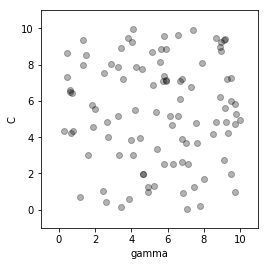

AUC for particle - 1 is 0.9730751945737169  At (gamma, c):  [5.89040121 7.13059851] .. Time =  17.52101731300354
AUC for particle - 2 is 0.9730713278276745  At (gamma, c):  [6.81325717 2.62872354] .. Time =  18.939502000808716
AUC for particle - 3 is 0.9725566370623896  At (gamma, c):  [9.08179158 2.73414383] .. Time =  20.15820050239563
AUC for particle - 4 is 0.9724664761846497  At (gamma, c):  [7.56602563 4.78078297] .. Time =  21.46503520011902
AUC for particle - 5 is 0.9733363012429104  At (gamma, c):  [5.36209774 5.37061155] .. Time =  18.203912019729614
AUC for particle - 6 is 0.9727715429757527  At (gamma, c):  [4.65138326 1.94299587] .. Time =  17.751442193984985
AUC for particle - 7 is 0.9719979083816145  At (gamma, c):  [8.91045621 8.95697758] .. Time =  21.2852144241333
AUC for particle - 8 is 0.9736738146119465  At (gamma, c):  [4.10416061 9.99612956] .. Time =  18.242955207824707
AUC for particle - 9 is 0.9730724922549966  At (gamma, c):  [5.90838026 7.12320289] .. Time =

AUC for particle - 73 is 0.9730712443065789  At (gamma, c):  [6.12176348 5.1512799 ] .. Time =  89.60119581222534
AUC for particle - 74 is 0.9730540932763484  At (gamma, c):  [5.88288519 8.84333345] .. Time =  83.08769583702087
AUC for particle - 75 is 0.9742787687754687  At (gamma, c):  [1.59918669 3.03634564] .. Time =  25.123887538909912
AUC for particle - 76 is 0.9706960281708436  At (gamma, c):  [0.64501758 4.22191494] .. Time =  30.23396348953247
AUC for particle - 77 is 0.9728189111574693  At (gamma, c):  [0.79379618 4.34334637] .. Time =  49.34993052482605
AUC for particle - 78 is 0.9735884165092544  At (gamma, c):  [4.26575771 7.86122772] .. Time =  93.23335385322571
AUC for particle - 79 is 0.9728658437483952  At (gamma, c):  [7.11599854 2.53692703] .. Time =  99.0198483467102
AUC for particle - 80 is 0.9741671348500889  At (gamma, c):  [2.72174218 4.02423469] .. Time =  59.970818519592285
AUC for particle - 81 is 0.9723526934869744  At (gamma, c):  [9.78923432 5.29429754] ..

KeyboardInterrupt: 

In [63]:
start = time()
while iteration < n_iterations:
    gbest_fitness_value_cadidate = np.array([0])
    gbest_position_cadidate = np.array([float('inf'), float('inf')])
    start1 = time()
    plot(particle_position_vector)
    
    for i in range(n_particles):
        start2 = time()
        fitness_cadidate = fitness_function(particle_position_vector[i])
        stop2 = time()
        print("AUC for particle -", i+1,"is", fitness_cadidate, " At (gamma, c): ", particle_position_vector[i], ".. Time = ", stop2 - start2)
        
        if(pbest_fitness_value[i] < fitness_cadidate):
            pbest_fitness_value[i] = fitness_cadidate
            pbest_position[i] = particle_position_vector[i]

        if(gbest_fitness_value_cadidate < fitness_cadidate):
            gbest_fitness_value_cadidate = fitness_cadidate
            gbest_position_cadidate = particle_position_vector[i]
        
    print("The best position in iteration number", iteration + 1, "is", gbest_position_cadidate, "with AUC:", fitness_function(gbest_position_cadidate))
    
   # if(gbest_fitness_value < gbest_fitness_value_cadidate):
    #    gbest_fitness_value = gbest_fitness_value_cadidate
     #   gbest_position = gbest_position_cadidate
    #print("The best position so far is ", gbest_position, "in iteration number", iteration + 1, "with AUC:", fitness_function(gbest_position))
    
    for i in range(n_particles):
        new_velocity = khi*(velocity_vector[i] + (c1*random.random()) * (pbest_position[i] - particle_position_vector[i]) + (c2*random.random()) * (gbest_position_cadidate-particle_position_vector[i]))
        new_velocity = eval_velocity(new_velocity)
        particle_position_vector[i] = new_velocity + particle_position_vector[i]
        particle_position_vector[i] = eval_position(particle_position_vector[i])
    
    iteration = iteration + 1
    stop1 = time()
    sec = stop1-start1
    print(sec)
stop = time()
print(stop - start)